<a href="https://colab.research.google.com/github/nmuonko/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
# !pip install tensorflow==2.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import zipfile
import pandas as pd
import random
import seaborn as sns
import numpy as np
import os
import PIL
import pickle
from PIL import *
import cv2
import glob
from skimage import io
from sklearn.metrics import accuracy_score
from tensorflow.keras import Model  
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import DenseNet121 # 2017 architecture
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.layers import *
from tensorflow.keras import Model 
from tensorflow.keras.models import load_model
from tensorflow import keras 
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from prettytable import PrettyTable
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from pathlib import Path
import cv2 as cv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## References

**Res-U-Net Explanation**
https://www.kaggle.com/ekhtiar/resunet-a-baseline-on-tensorflow#Loss-Functions
<br>
https://towardsdatascience.com/introduction-to-u-net-and-res-net-for-image-segmentation-9afcb432ee2f

## Loading Dataset and Exploratory Data Analysis

In [ ]:
brain_df = pd.read_csv('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/data_mask.csv')

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df.isnull().sum()

patient_id    0
image_path    0
mask_path     0
mask          0
dtype: int64

In [ ]:
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [ ]:
patient_id_dict = set()

In [ ]:
for x in brain_df.patient_id:
    patient_id_dict.add('_'.join((str(x).split('_')[:-1])))

In [ ]:
len(patient_id_dict)

110

In [ ]:
brain_df.shape

(3929, 4)

In [ ]:
brain_df['mask_path'][0]

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif'

In [ ]:
df_detail = pd.read_csv('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/data_detailed.csv')

In [ ]:
df_detail.head()

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0

In [ ]:
print("Number of patients:", df_detail.Patient.nunique())

Number of patients: 110


In [ ]:
df_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
df_detail.columns

Index(['Patient', 'RNASeqCluster', 'MethylationCluster', 'miRNACluster',
       'CNCluster', 'RPPACluster', 'OncosignCluster', 'COCCluster',
       'histological_type', 'neoplasm_histologic_grade', 'tumor_tissue_site',
       'laterality', 'tumor_location', 'gender', 'age_at_initial_pathologic',
       'race', 'ethnicity', 'death01'],
      dtype='object')

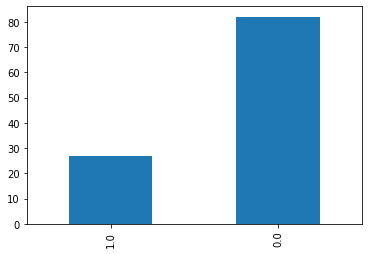

In [ ]:
df_detail.death01.value_counts().sort_values().plot(kind = 'bar')

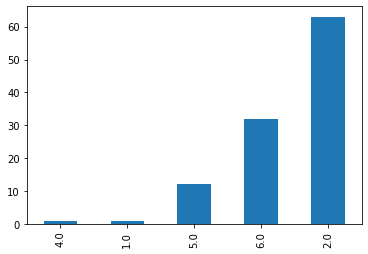

In [ ]:
df_detail.tumor_location.value_counts().sort_values().plot(kind = 'bar')

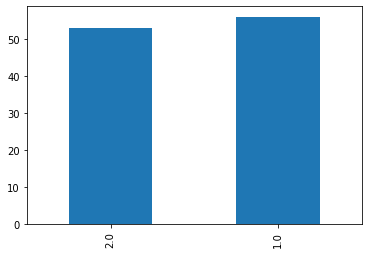

In [ ]:
df_detail.gender.value_counts().sort_values().plot(kind = 'bar')

### MASK
- **What Is Mask?**
    - The goal of image segmentation is to understand image at the pixel level. It associates each pixel with a certian class. The output produced by image segementation model is called **MASK** of the image.
- Mask can be represented by associating pixel values with their coordinates for example it we have a black image of shape (2,2) this can be represented as:
[[0,0],
[0,0]]
- If our output mask is as follows:
[[255,0],
[0,255]]

- To represent this mask we have to first flatten the image into a 1-D array. this would result in something like [255,0,0,255] for mask . then we can use the index to create the mask. finally we would have something like [1,0,0,1] as our mask.

In [ ]:
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [ ]:
brain_df['mask'].unique()

array([0, 1])

In [ ]:
brain_df['mask'].unique()

array([0, 1])

In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
brain_df.dtypes

patient_id    object
image_path    object
mask_path     object
mask           int64
dtype: object

In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
brain_df.shape, df_detail.shape

((3929, 4), (110, 18))

In [ ]:
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [ ]:
df_detail.Patient.nunique(), brain_df.patient_id.nunique()

(110, 110)

In [ ]:
p = Path('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning')

In [ ]:
folders = list(p.glob('./**'))
folders

[PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning'),
 PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/.git'),
 PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/.git/logs'),
 PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/.git/logs/refs'),
 PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/.git/logs/refs/heads'),
 PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/.git/logs/refs/remotes'),
 PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/.git/logs/refs/remotes/origin'),
 PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/.git/hooks'),
 PosixPath('/content/drive/MyDrive/AI Projects and Da

In [ ]:
for x in folders:
    currentFolder = list(x.glob('./**')) # folders
    for y in currentFolder:
        files = list(y.glob('./*'))
        print('FOLDER NAME:'," ", y)
        print(files)
        print()
        
    print()

FOLDER NAME:   /content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning
[PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/data_detailed.csv'), PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/classifier-resnet-weights.hdf5'), PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/classifier-resnet-model.json'), PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/classifier-resnet-weights_fine_tuning_16b_345_2.hdf5'), PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/model_fine_tuning_16b_345_2.json'), PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/res-unet-weights1.hdf5'), PosixPath('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep

In [ ]:
brain_df.mask_path[63]

'TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif'

In [ ]:
pth = "/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/"

In [ ]:
glob.glob(pth + brain_df.mask_path[623])

['/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_6_mask.tif']

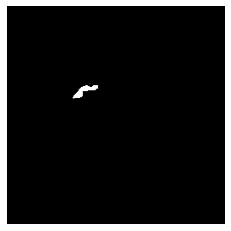

In [ ]:
# im_plt = plt.imread(brain_df.mask_path[623])
im_cv = cv.imread(pth + brain_df.mask_path[623])[:, :, ::-1] #OpenCV users BGR instead of RGB
plt.axis("off")
# plt.imshow(im_plt)
plt.imshow(im_cv) # works
plt.show()

In [ ]:
def edit_path(mask_path:str):
  mask_path = "/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/" + mask_path
  return mask_path

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [ ]:
brain_df.mask_path = brain_df.mask_path.progress_apply(lambda x: edit_path(x))

  0%|          | 0/3929 [00:00<?, ?it/s]

In [ ]:
brain_df.image_path = brain_df.image_path.progress_apply(lambda x: edit_path(x))

  0%|          | 0/3929 [00:00<?, ?it/s]

In [ ]:
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  /content/drive/MyDrive/AI Projects and Dataset...   
1  TCGA_CS_5395_19981004  /content/drive/MyDrive/AI Projects and Dataset...   
2  TCGA_CS_5395_19981004  /content/drive/MyDrive/AI Projects and Dataset...   
3  TCGA_CS_5395_19981004  /content/drive/MyDrive/AI Projects and Dataset...   
4  TCGA_CS_5395_19981004  /content/drive/MyDrive/AI Projects and Dataset...   

                                           mask_path  mask  
0  /content/drive/MyDrive/AI Projects and Dataset...     0  
1  /content/drive/MyDrive/AI Projects and Dataset...     0  
2  /content/drive/MyDrive/AI Projects and Dataset...     0  
3  /content/drive/MyDrive/AI Projects and Dataset...     0  
4  /content/drive/MyDrive/AI Projects and Dataset...     0

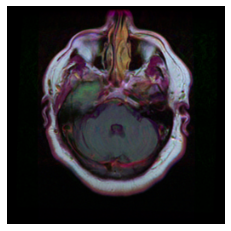

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[623]))
plt.axis("off")
plt.show()

In [ ]:
print(im_cv)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [ ]:
brain_df.mask_path[122]

'/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_2_mask.tif'

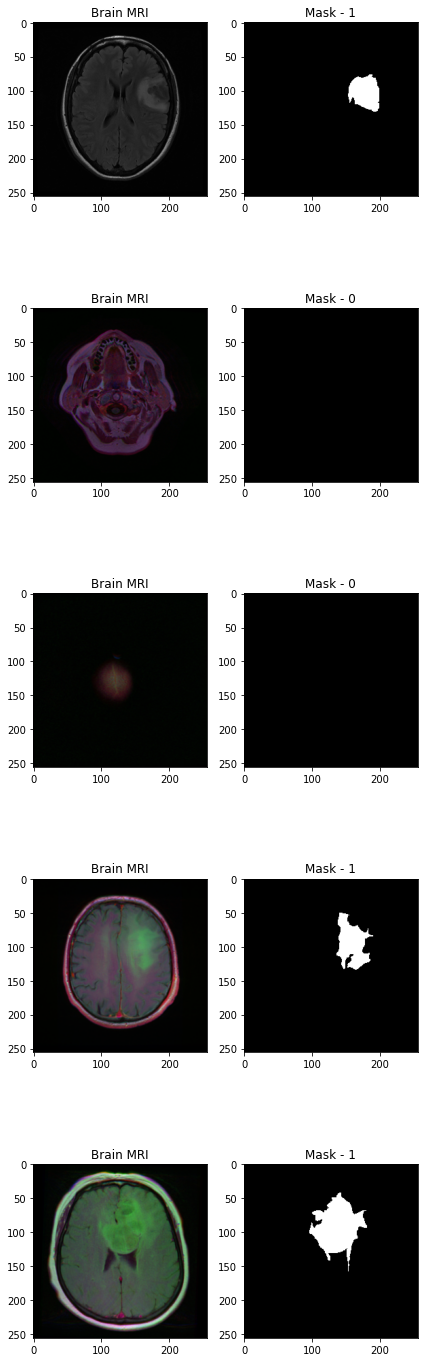

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(6,20))
count = 0
for x in range(5):
    i = random.randint(0, len(brain_df))
    axs[count][0].title.set_text("Brain MRI") 
    axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) 
    axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
    axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
    count += 1

fig.tight_layout()

In [ ]:
def display_mri_mask(df:pd.DataFrame, no_images = 12):
    count = 0
    fig, axs = plt.subplots(12, 3, figsize = (15, 40))  # default 12 rows and 3 columns each for MRI, MASK and MRI with MASK
    for i in range(len(df)):
        if df['mask'][i] == 1 and count < no_images:

            # Print MRIs without mask
            img = io.imread(df.image_path[i]) # read image from path brain_df.image_path[i] and store its numerical/matrix representation into variable img 
            axs[count][0].title.set_text('Brain MRI') # Add Title to image
            axs[count][0].imshow(img) # Display Image

            mask = io.imread(df.mask_path[i])  # same for mask
            axs[count][1].title.set_text('Mask') # add title
            axs[count][1].imshow(mask, cmap = 'gray') # display


            img[mask == 255] = (255, 0, 0) # highlighting tumor
            axs[count][2].title.set_text('MRI with Mask')
            axs[count][2].imshow(img)
            count+=1
    fig.tight_layout()       

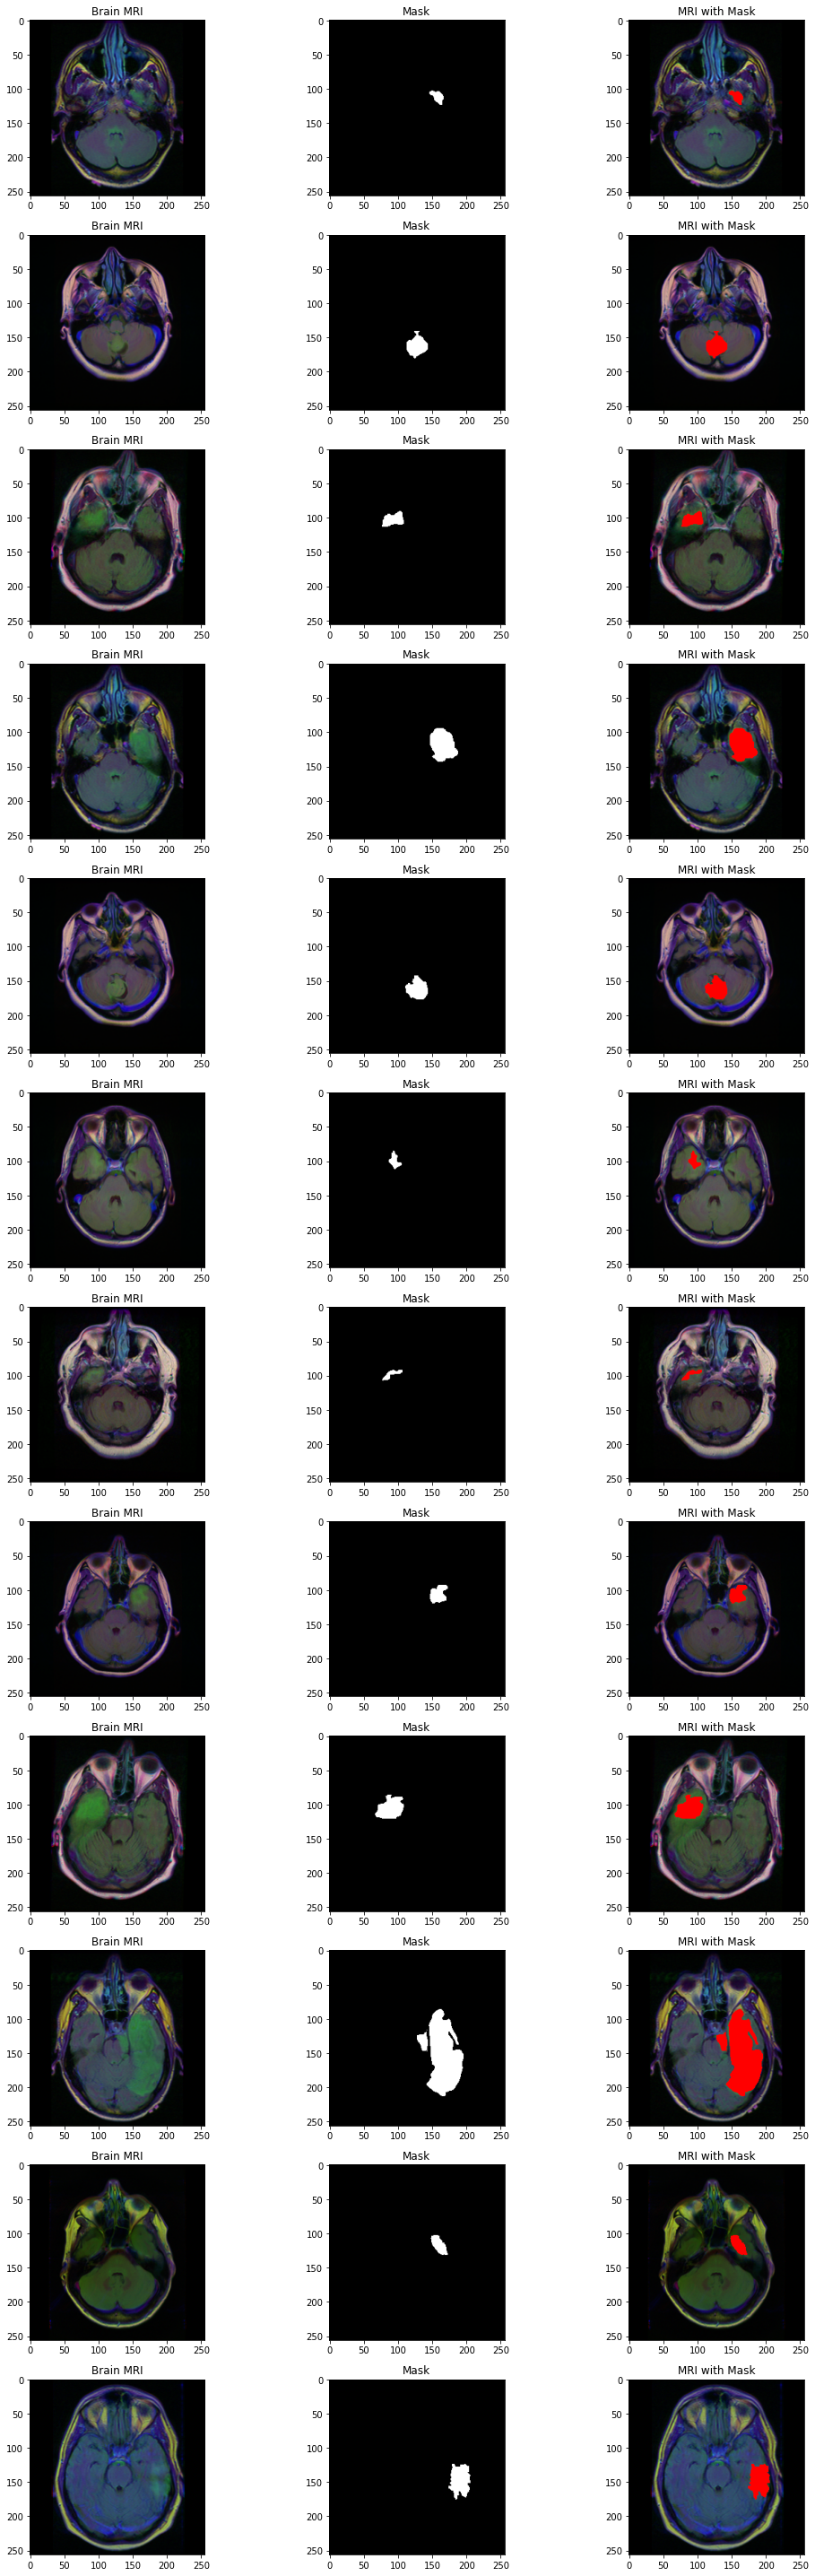

In [ ]:
display_mri_mask(brain_df)

In [ ]:
img = io.imread(brain_df.image_path[0])
type(img), len(img)

(numpy.ndarray, 256)

## Tumor Classification

In [ ]:
brain_df_training = brain_df.drop(columns=['patient_id'])
brain_df_training.shape

(3929, 3)

In [ ]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if we comment out the this code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_training['mask'] = brain_df_training['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
train, test = train_test_split(brain_df_training, test_size = 0.23)

## Data Prepration
- Before we use our dataset for training we do data/image augmentation
- More data can help our model to give better performance
- Image Augmentation is techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data
- To do this I am using keras

###### https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

In [ ]:
def train_val_test_data_gen(TRAIN:pd.DataFrame,TRAIN_PATH:str, VAL:pd.DataFrame, VAL_PATH:str, TEST:pd.DataFrame, 
                            TEXT_PATH:str, CLASS_MODE: str, BATCH_SIZE=16, IMAGE_SHAPE = (256,256)):
    # Create a data generator which scales the data in range  [0, 1] and makes validation split of 30%
    datagen = ImageDataGenerator(
                                 rescale=1./255., # normalize
                                 validation_split = 0.30)
    
    train_generator=datagen.flow_from_dataframe(
                                                    dataframe=TRAIN,
                                                    directory= TRAIN_PATH,
                                                    x_col='image_path',
                                                    y_col='mask',
                                                    subset="training",
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode=CLASS_MODE,
                                                    target_size=IMAGE_SHAPE)


    val_generator=datagen.flow_from_dataframe(
                                                    dataframe=VAL,
                                                    directory= VAL_PATH,
                                                    x_col='image_path',
                                                    y_col='mask',
                                                    subset="validation",
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode=CLASS_MODE,
                                                    target_size=IMAGE_SHAPE)

    # Create a data generator for test images
    test_datagen=ImageDataGenerator(rescale=1./255.) # Scaling data to the range of 0-1 is traditionally referred to as normalization.

    test_generator=test_datagen.flow_from_dataframe(
                                                    dataframe=TEST,
                                                    directory= TEXT_PATH,
                                                    x_col='image_path',
                                                    y_col='mask',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    class_mode=CLASS_MODE,
                                                    target_size=IMAGE_SHAPE)

    return train_generator, val_generator, test_generator

In [ ]:
TRAIN = train
VAL = train
TEST = test
TRAIN_PATH = TEST_PATH = VAL_PATH = './'
BATCH_SIZE = 16
CLASS_MODE = "categorical"
train_generator, valid_generator, test_generator = train_val_test_data_gen(TRAIN, TRAIN_PATH, VAL, VAL_PATH, TEST, TEST_PATH, CLASS_MODE, BATCH_SIZE)

Found 2118 validated image filenames belonging to 2 classes.
Found 907 validated image filenames belonging to 2 classes.
Found 904 validated image filenames belonging to 2 classes.


## ResNet 50 Transfer Learning

#### Why ResNet50?
- 50 Layers deep
- Skip Connection to banish vanishing gradient and no loss of information between layers


## Transfer Learning
- Transfer learning is a research problem in Deep learning (DL) that focuses on storing knowledge gained while training one model and applying it to another model here we are using ResNet50.
- How it works?
    All we need to do is delete or remove the last layer in the network and replace it with a new layer. Also, the weights associated with the last layer are re-initialized and the model is trained using the images instead of deleting/removing last layer we can also add several layers.
- There are various other approaches to implement it, that can be used depending upon the type of problem.
- Here I will freeze the existing layers while training the model with the MRI data-set, meaning that the weights in these layers are not changed. During the training process, only the randomly initialized weights associated with newly added layers are changed until they converge. This process is also known as **fine-tuning**
- Fine-tuning is one approach to transfer learning where you change the model output to fit the new task and train only the output model. In Transfer Learning or Domain Adaptation, we train the model with a dataset.

#### Fine Tuning
- Here I will freeze weights of ResNet50 model.
- This approach is better when the data available for training is less and the task for which the existing model is trained is similar to the task we are interested in.

#### What does Freezing a Layer mean?
- Freezing a layer prevents its weights from being modified here the base model(trained on imagenet dataset)is frozen.
- We will only train addition layers that I will add in the end of basemodel, this will make faster training


#### Adding Classification Layer
- Once basemodel layers are freezed we can move ahead and add new layers for classification of MRIs
- https://learnopencv.com/number-of-parameters-and-tensor-sizes-in-convolutional-neural-network/#:~:text=In%20a%20CNN%2C%20each%20layer,of%20all%20weights%20and%20biases.&text=%3D%20Number%20of%20biases%20of%20the,used%20in%20the%20Conv%20Layer
- A dense layer also referred to as a fully connected layer is a layer that is used in the final stages of the neural network. This layer helps in changing the dimensionality of the output from the preceding layer so that the model can easily define the relationship between the values of the data in which the model is working.
- https://analyticsindiamag.com/a-complete-understanding-of-dense-layers-in-neural-networks/
- Choosing size of dense layer : https://stackoverflow.com/questions/36950394/how-to-decide-the-size-of-layers-in-keras-dense-method/53120987
- Choosing Activation function: https://stats.stackexchange.com/questions/218542/which-activation-function-for-output-layer
- Choosing activation function for output layer: https://stats.stackexchange.com/questions/218542/which-activation-function-for-output-layer#:~:text=Use%20simple%20sigmoid%20only%20if%20your%20output%20admits%20multiple%20%22true%22%20answers 

In [ ]:
# Fine tuning ResNet50 Base model
def build_resnet50_model():
    # Get the ResNet50 base model transfer learning
    basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))
    for layer in basemodel.layers:
        layers.trainable = False
    # Add classification head to the basemodel
    head = basemodel.output
    head = AveragePooling2D(pool_size = (4,4))(head) # Apply averagePooling2D on headmodel
    head = Flatten(name= 'flatten')(head) # flatten it
    head = Dense(256, activation = "relu")(head) # relu to overcome gradient decent problem 
    head = Dropout(0.3)(head) # to prevent overfitting
    head = Dense(256, activation = "relu")(head)
    head = Dropout(0.3)(head)
    head = Dense(128, activation = "relu")(head)
    head = Dropout(0.3)(head)
    head = Dense(2, activation = 'softmax')(head) # "Softmax" Activation layer for classification
    model = Model(inputs = basemodel.input, outputs = head)
    return model

headmodel = Dense(2, activation = 'softmax')(headmodel)
Since the final layer outputs (2) probability for each classes, we use "categorical_crossentropy". 
https://stackoverflow.com/questions/45793856/binary-classification-with-softmax
categorical cross entropy loss: If we use categorical cross entropy loss function, then we provide the ground truth as an n-dimensional vector in which all entries are 0 except the entry corresponding to the class, which is 1 (one-hot-encoding).

Sparse categorical cross entropy loss: If we use sparse categorical cross entropy then we provide the ground truth as single integer unit only rather than as an n-dimensional vector. Here the integer represents the class of the data.

In [ ]:
model_resnet = build_resnet50_model()

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

- Since, we are using Softmax activation function in our output layer of the new model.
- Softmax gives probablity of each class, which sums up to be 1 or 100%
- for binary_crossentropy: sigmoid activation, scalar target
- for categorical_crossentropy: softmax activation, one-hot encoded target
- Optimizers : https://ruder.io/optimizing-gradient-descent/index.html#adam

In [ ]:
# compilations of model
model_resnet.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])

- https://www.educative.io/edpresso/what-is-early-stopping
- Verbose in earlystopping take value of 0/1.
- If you put Verbose value as 1 in ModelCheckPoint callback, after every epoch you will get a statement like Model improved from error this to that or nor change in loss
- In EarlyStopping, whenever your training gets stopped due to not improving the model, a log says Stopped training bcoz your model did not improved

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))


In [ ]:
def lf_schedule(epoch,lr):
    if epoch%3 ==0:
        lr=lr - 0.05*lr #-->i.e. 0.95*lr (5% decay)
        print(f'New learning rate for epoch={epoch} is {lr}')
        return lr
    else:
        return lr

- https://rdrr.io/cran/kerasR/man/ReduceLROnPlateau.html
- https://keras.io/api/callbacks/model_checkpoint/

In [ ]:
def make_callback_earlystop(MODEL_WEIGHT_NAME:str):
    
    # use early stopping to exit training if validation loss is not decreasing even after certain epochs
    callback1 = EarlyStopping( monitor="val_accuracy", patience=2, verbose=1, mode="auto", min_delta=0)
    # If validation accuracy at current epoch is less than previous epoch accuracy, decrease the learning rate by factor of 10%. 
    callback2 = ReduceLROnPlateau( monitor="val_accuracy", factor=0.05, patience=1, verbose=1, mode="auto")
    # For every 3rd epoch, decay learning rate by 5%
    callback3 = LearningRateScheduler( schedule=lf_schedule, verbose=1)
    # save the best model with least validation loss
    checkpointer = ModelCheckpoint(filepath=f"{MODEL_WEIGHT_NAME}.hdf5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="auto")
    return checkpointer, callback1, callback2, callback3


- train_generator.n = gives size of train dataset

In [ ]:
checkpointer, callback1, callback2, callback3 = make_callback_earlystop("classifier-resnet-weights")

In [ ]:
history = model_resnet.fit(train_generator, 
                    steps_per_epoch= train_generator.n // 64, 
                    epochs = 100, validation_data= valid_generator, validation_steps= valid_generator.n // 64, callbacks=[checkpointer, callback1, callback2, callback3])

In [ ]:
# # save the model architecture to json file for future use
model_json = model_resnet.to_json()
with open("classifier-resnet-model.json","w") as json_file:
      json_file.write(model_json)

In [ ]:
# Load pretrained model
with open('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/classifier-resnet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model_resnet = tf.keras.models.model_from_json(json_savedModel)
model_resnet.load_weights('/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/classifier-resnet-weights.hdf5')
model_resnet.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
def model_prediction(model, MODEL_NAME:str, test_generator, BINARY = False):
    test_predict = model.predict(test_generator, steps = test_generator.n // 32, verbose =1)
    # Obtain the predicted class from the model prediction
    predict = []
    if(BINARY):
        _,accuracy = model.evaluate_generator(generator=test_generator,steps=len(test_generator))
        print(MODEL_NAME,"accuracy:",np.round(accuracy*100,4),"%")
        test_predict = model.predict(test_generator, steps = test_generator.n // 32, verbose =1)
        for i in test_predict:
            if i[0]>0.4:
                predict.append(1)
            else:
                predict.append(0)
        predict = np.asarray(predict)
        original = np.asarray(test['mask'])[:len(predict)]
        original = original.astype('int64', copy=False)
        predict = predict.astype('int64', copy=False)
    else:
        for i in test_predict:
            predict.append(str(np.argmax(i)))
        predict = np.asarray(predict)
        original = np.asarray(test['mask'])[:len(predict)]
            
    accuracy = accuracy_score(original, predict)
    bal_acc = balanced_accuracy_score(original, predict)
    recall =  recall_score(original, predict, average='micro')
    f1_weighted = f1_score(original, predict, average='weighted')
    f1_average = f1_score(original, predict, average='micro')
    precision = precision_score(original, predict, average='micro')
    print()
    print(MODEL_NAME,"accuracy:",np.round(accuracy*100,4),"%")
    print(MODEL_NAME,"balanced accuracy :",np.round(bal_acc*100,4),"%")
    print(MODEL_NAME,"recall:",np.round(recall*100,4),"%")
    print(MODEL_NAME,"f1_weighted:",np.round(f1_weighted*100,4),"%")
    print(MODEL_NAME,"f1_average:",np.round(f1_average*100,4),"%")
    print(MODEL_NAME,"precision:",np.round(precision*100,4),"%")
    print()
    # plotting the confusion matrix
    cm = confusion_matrix(original, predict)
    plt.figure(figsize = (7,7))
    sns.heatmap(cm, annot=True)
    print()
    report = classification_report(original, predict, labels = [0,1])
    print((report))

28/28 [==============================] - 211s 8s/step

Resnet50 Model accuracy: 98.8839 %
Resnet50 Model balanced accuracy : 98.7153 %
Resnet50 Model recall: 98.8839 %
Resnet50 Model f1_weighted: 98.8831 %
Resnet50 Model f1_average: 98.8839 %
Resnet50 Model precision: 98.8839 %


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       288
           1       0.99      0.98      0.98       160

   micro avg       0.99      0.99      0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



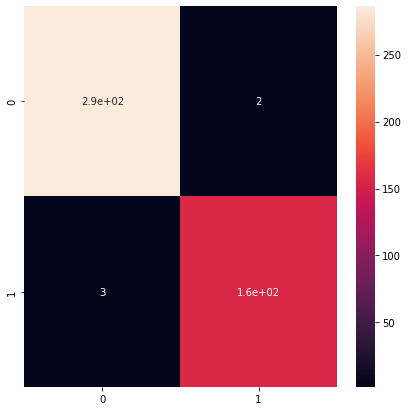

In [ ]:
model_prediction(model_resnet, "Resnet50 Model", test_generator)

## Model #2: VGG16 Tranfer Learning

In [ ]:
train, test = train_test_split(brain_df_training, test_size = 0.23)
TRAIN = train
VAL = train
TEST = test
TRAIN_PATH = TEST_PATH = VAL_PATH = './'
BATCH_SIZE = 16
CLASS_MODE = "categorical"
IMAGE_SHAPE = (224,224)
train_generator, valid_generator, test_generator = train_val_test_data_gen(TRAIN, 
                                                                           TRAIN_PATH, 
                                                                           VAL, 
                                                                           VAL_PATH, 
                                                                           TEST, 
                                                                           TEST_PATH, 
                                                                           CLASS_MODE, 
                                                                           BATCH_SIZE,
                                                                           IMAGE_SHAPE)

Found 2118 validated image filenames belonging to 2 classes.
Found 907 validated image filenames belonging to 2 classes.
Found 904 validated image filenames belonging to 2 classes.


In [ ]:
train_generator[0][0].shape

(16, 224, 224, 3)

In [ ]:
%tensorflow_version 

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


In [ ]:
def model1_vgg16():
    base_model_1 = VGG16(weights="imagenet", include_top=False, input_tensor = Input(shape=(224,224,3)))
    for layer in base_model_1.layers:
        layers.trainable = False
    # Add classification head to the basemodel
    head = base_model_1.output
    head = Flatten()(head)
    head = Dense(units=128,activation='relu',kernel_initializer="he_uniform")(head)
    head = Dense(2, activation = 'softmax')(head)
    model_vgg = Model(inputs = base_model_1.input, outputs = head)
    return model_vgg

In [ ]:
model_1_vgg_16 = model1_vgg16()
model_1_vgg_16.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics =['accuracy'])

In [ ]:
checkpointer, callback1, callback2, callback3 = make_callback_earlystop("model_1_vgg_16_weights")

In [ ]:
history_vgg = model_1_vgg_16.fit(train_generator, 
                    steps_per_epoch= train_generator.n // BATCH_SIZE, 
                    epochs = 20, validation_data= valid_generator, 
                    validation_steps= valid_generator.n // BATCH_SIZE, 
                    callbacks=[checkpointer, callback1, callback2, callback3])

New learning rate for epoch=0 is 0.0009500000451225787

Epoch 1: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/20
132/132 [==============================] - ETA: 0s - loss: 0.9022 - accuracy: 0.6470
Epoch 1: val_accuracy improved from -inf to 0.63504, saving model to model_1_vgg_16_weights.hdf5
132/132 [==============================] - 668s 5s/step - loss: 0.9022 - accuracy: 0.6470 - val_loss: 0.6626 - val_accuracy: 0.6350 - lr: 9.5000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/20
132/132 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.6694
Epoch 2: val_accuracy improved from 0.63504 to 0.75000, saving model to model_1_vgg_16_weights.hdf5
132/132 [==============================] - 35s 261ms/step - loss: 0.5964 - accuracy: 0.6694 - val_loss: 0.4907 - val_accuracy: 0.7500 - lr: 9.5000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/20
132/1

Lowest Validation Loss: epoch 6
Highest Validation Accuracy: epoch 7


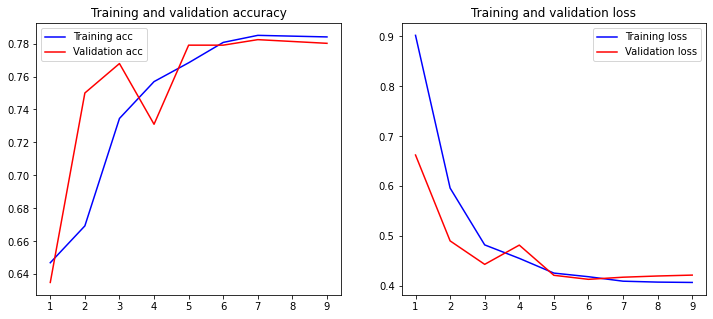

In [ ]:
plot_history(history_vgg)

Selecting Step Size => steps_per_epoch * batch_size = number_of_rows_in_train_da
https://datascience.stackexchange.com/questions/47405/what-to-set-in-steps-per-epoch-in-keras-fit-generator

https://stackoverflow.com/questions/56207651/why-doesnt-the-accuracy-when-training-vgg-16-change-much
- needs to be trained on more epochs which will require time and computation powers :)

In [ ]:
# save the model architecture to json file for future use
model_json = model_1_vgg_16.to_json()
with open("classifier-vgg16-model1.json","w") as json_file:
      json_file.write(model_json)

In [ ]:
with open('classifier-vgg16-model1.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model1_vgg16 = tf.keras.models.model_from_json(json_savedModel)
model1_vgg16.load_weights('model_1_vgg_16_weights.hdf5')
model1_vgg16.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

28/28 [==============================] - 101s 4s/step

VGG16 Model 1 accuracy: 82.1429 %
VGG16 Model 1 balanced accuracy : 82.6822 %
VGG16 Model 1 recall: 82.1429 %
VGG16 Model 1 f1_weighted: 82.3992 %
VGG16 Model 1 f1_average: 82.1429 %
VGG16 Model 1 precision: 82.1429 %


              precision    recall  f1-score   support

           0       0.90      0.81      0.85       285
           1       0.72      0.85      0.78       163

   micro avg       0.82      0.82      0.82       448
   macro avg       0.81      0.83      0.81       448
weighted avg       0.83      0.82      0.82       448



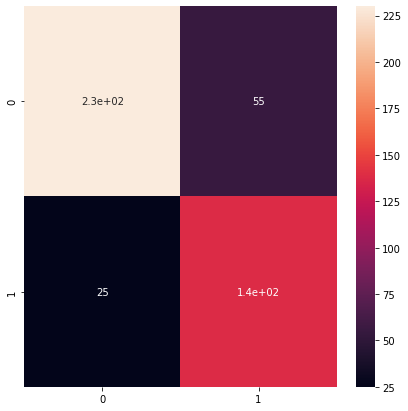

In [ ]:
model_prediction(model1_vgg16, "VGG16 Model 1", test_generator, False)

In [ ]:
train, test = train_test_split(brain_df_training, test_size = 0.23)
TRAIN = train
VAL = train
TEST = test
TRAIN_PATH = TEST_PATH = VAL_PATH = './'
BATCH_SIZE = 16
CLASS_MODE = "categorical"
IMAGE_SHAPE = (256,256)
train_generator, valid_generator, test_generator = train_val_test_data_gen(TRAIN, 
                                                                           TRAIN_PATH, 
                                                                           VAL, 
                                                                           VAL_PATH, 
                                                                           TEST, 
                                                                           TEST_PATH, 
                                                                           CLASS_MODE, 
                                                                           BATCH_SIZE,
                                                                           IMAGE_SHAPE)

Found 2118 validated image filenames belonging to 2 classes.
Found 907 validated image filenames belonging to 2 classes.
Found 904 validated image filenames belonging to 2 classes.


In [ ]:
def CNN_MODEL():
    model=Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(256,256,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(256,256,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(256,256,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=128,activation="relu",kernel_initializer="he_uniform"))
    model.add(Dropout(0.5))
    model.add(Dense(units=2,activation="softmax"))
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
    return model

In [ ]:
checkpointer, callback1, callback2, callback3 = make_callback_earlystop("CNN_MODEL_weights")

In [ ]:
model_cnn=CNN_MODEL()
history = model_cnn.fit(train_generator,
                              steps_per_epoch=train_generator.n // BATCH_SIZE,
                              validation_data=train_generator,
                              validation_steps=valid_generator.n // BATCH_SIZE,
                              epochs=20,
                              callbacks=[checkpointer, callback1, callback2, callback3])

New learning rate for epoch=0 is 0.0009500000451225787

Epoch 1: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/20
132/132 [==============================] - ETA: 0s - loss: 0.9126 - accuracy: 0.7122
Epoch 1: val_accuracy improved from -inf to 0.76451, saving model to CNN_MODEL_weights.hdf5
132/132 [==============================] - 13s 91ms/step - loss: 0.9126 - accuracy: 0.7122 - val_loss: 0.4637 - val_accuracy: 0.7645 - lr: 9.5000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/20
132/132 [==============================] - ETA: 0s - loss: 0.4587 - accuracy: 0.7721
Epoch 2: val_accuracy improved from 0.76451 to 0.77790, saving model to CNN_MODEL_weights.hdf5
132/132 [==============================] - 11s 87ms/step - loss: 0.4587 - accuracy: 0.7721 - val_loss: 0.4331 - val_accuracy: 0.7779 - lr: 9.5000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/20
132/132 [======

Lowest Validation Loss: epoch 13
Highest Validation Accuracy: epoch 13


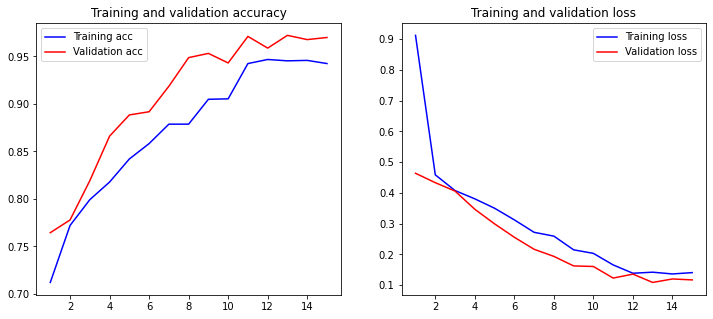

In [ ]:
plot_history(history)

Higher Validation Accuracy Issue:https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras#:~:text=This%20indicates%20the%20presence%20of%20high%20bias%20in%20your%20dataset.%20It%20is%20underfitting.%20The%20solutions%20to%20issue%20are%3A

In [ ]:
model_cnn.save_weights('CNN_MODEL_weights.hdf5')

In [ ]:
model_json = model_cnn.to_json()
with open("CNN_MODEL.json","w") as json_file:
      json_file.write(model_json)

In [ ]:
with open('CNN_MODEL.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  |
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('CNN_MODEL_weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

28/28 [==============================] - 2s 56ms/step

CNN Model accuracy: 88.6161 %
CNN Model balanced accuracy : 87.1387 %
CNN Model recall: 88.6161 %
CNN Model f1_weighted: 88.6066 %
CNN Model f1_average: 88.6161 %
CNN Model precision: 88.6161 %


              precision    recall  f1-score   support

           0       0.91      0.92      0.91       298
           1       0.83      0.83      0.83       150

   micro avg       0.89      0.89      0.89       448
   macro avg       0.87      0.87      0.87       448
weighted avg       0.89      0.89      0.89       448



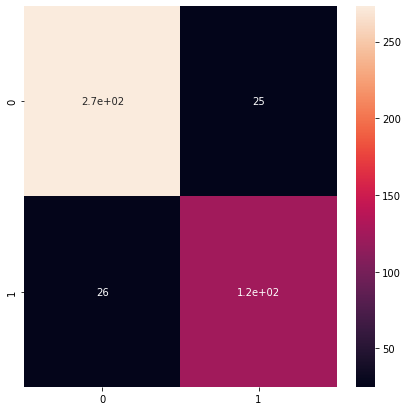

In [ ]:
model_prediction(model_cnn, "CNN Model", test_generator)

## VGG Model #2

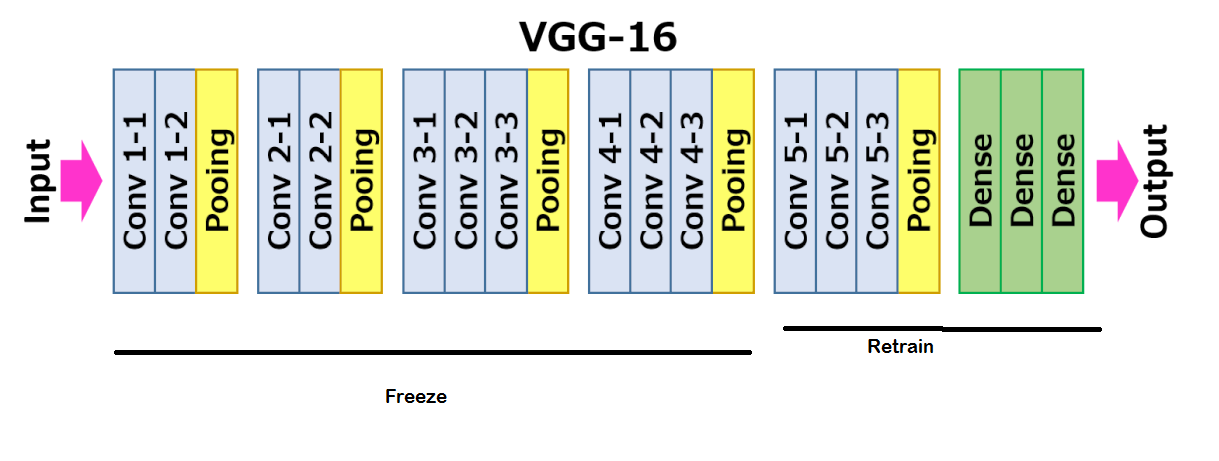

In [ ]:
train, test = train_test_split(brain_df_training, test_size = 0.23)
TRAIN = train
VAL = train
TEST = test
TRAIN_PATH = TEST_PATH = VAL_PATH = './'
BATCH_SIZE = 16
CLASS_MODE = "categorical"
IMAGE_SHAPE = (224,224)
train_generator, valid_generator, test_generator = train_val_test_data_gen(TRAIN, 
                                                                           TRAIN_PATH, 
                                                                           VAL, 
                                                                           VAL_PATH, 
                                                                           TEST, 
                                                                           TEST_PATH, 
                                                                           CLASS_MODE, 
                                                                           BATCH_SIZE,
                                                                           IMAGE_SHAPE)

Found 2118 validated image filenames belonging to 2 classes.
Found 907 validated image filenames belonging to 2 classes.
Found 904 validated image filenames belonging to 2 classes.


In [ ]:
checkpointer, callback1, callback2, callback3 = make_callback_earlystop("VGG_MODEL_2_weights")

In [ ]:
def VGG_MODEL_2():    
    basemodel=VGG16(include_top=False,input_shape=(224,224,3))
    for layer in basemodel.layers:
        layer.trainable=False
    head = basemodel.output
    head = AveragePooling2D(pool_size = (4,4))(head) # Apply averagePooling2D on headmodel
    head = Flatten(name= 'flatten')(head) # flatten it
    head = Dense(512, activation = "relu")(head) # relu to overcome gradient decent problem 
    head = Dropout(0.3)(head) # to prevent overfitting
    head = Dense(256, activation = "relu")(head)
    head = Dropout(0.1)(head)
    head = Dense(128, activation = "relu")(head)
    head = Dense(2, activation = 'softmax')(head) # "Softmax" Activation layer for classification
    model = Model(inputs = basemodel.input, outputs = head)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])  
    return model

In [ ]:
model=VGG_MODEL_2()
history = model.fit(train_generator,
                              steps_per_epoch=train_generator.n//BATCH_SIZE,
                              validation_data=train_generator,
                              validation_steps=valid_generator.n // BATCH_SIZE,
                              epochs=20,
                              callbacks=[checkpointer, callback1,callback2,callback3])

New learning rate for epoch=0 is 0.0009500000451225787

Epoch 1: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/20
132/132 [==============================] - ETA: 0s - loss: 0.5137 - accuracy: 0.7336
Epoch 1: val_accuracy improved from -inf to 0.77121, saving model to VGG_MODEL_2_weights.hdf5
132/132 [==============================] - 17s 121ms/step - loss: 0.5137 - accuracy: 0.7336 - val_loss: 0.4324 - val_accuracy: 0.7712 - lr: 9.5000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/20
132/132 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.7655
Epoch 2: val_accuracy improved from 0.77121 to 0.78571, saving model to VGG_MODEL_2_weights.hdf5
132/132 [==============================] - 16s 122ms/step - loss: 0.4540 - accuracy: 0.7655 - val_loss: 0.4149 - val_accuracy: 0.7857 - lr: 9.5000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/20
132/132 [

In [ ]:
model.save_weights('vgg16-model2-transfer-learning.hdf5')

In [ ]:
model_json = model.to_json()
with open("classifier-vgg16-model2-transfer-learning.json","w") as json_file:
      json_file.write(model_json)

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('classifier-vgg16-model2-transfer-learning.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('vgg16-model2-transfer-learning.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

Lowest Validation Loss: epoch 5
Highest Validation Accuracy: epoch 4


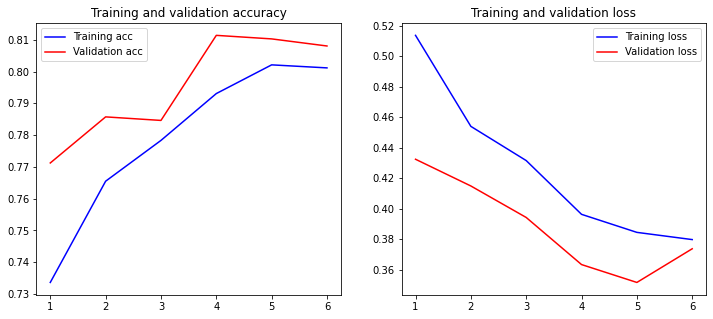

In [ ]:
plot_history(history)

28/28 [==============================] - 2s 84ms/step

VGG16 Model-2 accuracy: 83.0357 %
VGG16 Model-2 balanced accuracy : 81.509 %
VGG16 Model-2 recall: 83.0357 %
VGG16 Model-2 f1_weighted: 83.0864 %
VGG16 Model-2 f1_average: 83.0357 %
VGG16 Model-2 precision: 83.0357 %


              precision    recall  f1-score   support

           0       0.88      0.86      0.87       294
           1       0.75      0.77      0.76       154

   micro avg       0.83      0.83      0.83       448
   macro avg       0.81      0.82      0.81       448
weighted avg       0.83      0.83      0.83       448



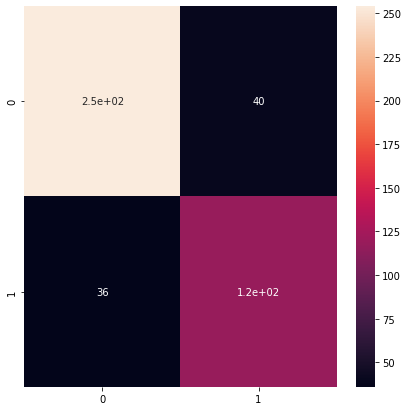

In [ ]:
model_prediction(model, "VGG16 Model-2", test_generator)

# Segmentation Model To Localize Tumor

In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
X_train

patient_id  \
3352  TCGA_HT_A5RC_19990831   
1964  TCGA_DU_A5TW_19980228   
3051  TCGA_HT_7877_19980917   
1542  TCGA_DU_7302_19911203   
2470  TCGA_FG_A60K_20040224   
...                     ...   
3019  TCGA_HT_7879_19981009   
3328  TCGA_HT_A616_19991226   
1399  TCGA_DU_8162_19961029   
2289  TCGA_FG_7637_20000922   
2741  TCGA_HT_7855_19951020   

                                             image_path  \
3352  /content/drive/MyDrive/AI Projects and Dataset...   
1964  /content/drive/MyDrive/AI Projects and Dataset...   
3051  /content/drive/MyDrive/AI Projects and Dataset...   
1542  /content/drive/MyDrive/AI Projects and Dataset...   
2470  /content/drive/MyDrive/AI Projects and Dataset...   
...                                                 ...   
3019  /content/drive/MyDrive/AI Projects and Dataset...   
3328  /content/drive/MyDrive/AI Projects and Dataset...   
1399  /content/drive/MyDrive/AI Projects and Dataset...   
2289  /content/drive/MyDrive/AI Projects and Dataset...   
2741  /content/drive/MyDrive/AI Projects and Dataset...   

                                              mask_path  mask  
3352  /content/drive/MyDrive/AI Projects and Dataset...     1  
1964  /content/drive/MyDrive/AI Projects and Dataset...     1  
3051  /content/drive/MyDrive/AI Projects and Dataset...     1  
1542  /content/drive/MyDrive/AI Projects and Dataset...     1  
2470  /content/drive/MyDrive/AI Projects and Dataset...     1  
...                                                 ...   ...  
3019  /content/drive/MyDrive/AI Projects and Dataset...     1  
3328  /content/drive/MyDrive/AI Projects and Dataset...     1  
1399  /content/drive/MyDrive/AI Projects and Dataset...     1  
2289  /content/drive/MyDrive/AI Projects and Dataset...     1  
2741  /content/drive/MyDrive/AI Projects and Dataset...     1  

[1167 rows x 4 columns]

In [ ]:
#separate list for imageId, classId to pass into the generator
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)
val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)
print(train_ids[0])
print(train_mask[0])
print(val_ids[0])
print(val_mask[0])

/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_37.tif
/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_37_mask.tif
/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_42.tif
/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_42_mask.tif


## Custom Datagenerator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = '', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path =  str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      mask -= mask.mean()
      mask /= mask.std()
      #Adding image to the empty array
      X[i,] = img
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

In [ ]:
#Utilities file contains the code for custom loss function and custom data generator
# from utilities import DataGenerator
#create image generators
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
training_generator[0]

(array([[[[-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554],
          ...,
          [-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554]],
 
         [[-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554],
          ...,
          [-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554]],
 
         [[-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554],
          ...,
          [-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554],
          [-0.96858554, -0.96858554, -0.96858554]],
 
         ...,
 
         [[-

In [ ]:
# @tf.function
def resblock(X, f):

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 
  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)
  # Adding the output from main path and short path together
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])
    return merge

In [ ]:
input_shape = (256,256,3)
# Input tensor shape
X_input = Input(input_shape)
# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)
# Stage 2
# pool_1 = tf.reshape
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)
# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)
# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)
# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)
# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)
# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)
# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)
# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)
# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)
model_seg = Model(inputs = X_input, outputs = output )

In [ ]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_49 (Conv2D)             (None, 256, 256, 16  448         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_48 (BatchN  (None, 256, 256, 16  64         ['conv2d_49[0][0]']              
 ormalization)                  )                                                           

### Loss function
- We need a custom loss function to train this ResUNet for image segmentation.So, we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py
- https://arxiv.org/pdf/1706.05721.pdf

In [ ]:
from tensorflow.keras import backend as K
def tversky(y_true, y_pred, smooth = 1e-6):
    y_true_pos =  tf.cast(K.flatten(y_true), tf.float32)
    y_pred_pos =  tf.cast(K.flatten(y_pred), tf.float32)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

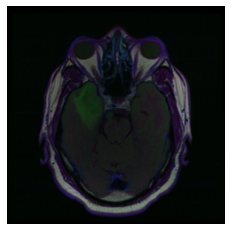

In [ ]:
# im_plt = plt.imread(brain_df.mask_path[623])
im_cv = cv.imread("/content/drive/MyDrive/AI Projects and Dataset/Detecting-Brain-Tumor-Using-Deep-Learning/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_11.tif")[:, :, ::-1] #OpenCV users BGR instead of RGB
plt.axis("off")
# plt.imshow(im_plt)
plt.imshow(im_cv) # works
plt.show()

In [ ]:
history = model_seg.fit(training_generator, epochs = 10, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.4846 - tversky: 0.6159
Epoch 1: val_loss improved from 0.78286 to 0.64332, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 25s 212ms/step - loss: 0.4846 - tversky: 0.6159 - val_loss: 0.6433 - val_tversky: 0.4428
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.3848 - tversky: 0.7181
Epoch 2: val_loss improved from 0.64332 to 0.40705, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 15s 204ms/step - loss: 0.3848 - tversky: 0.7181 - val_loss: 0.4071 - val_tversky: 0.6975
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.3344 - tversky: 0.7658
Epoch 3: val_loss improved from 0.40705 to 0.40296, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 15s 201ms/step - loss: 0.3344 - tversky: 0.7658 - val_loss: 0.4030 - val_tversky: 0.7011
Epoch 4/10
72/72 [==============================] - ETA: 0s - lo

In [ ]:
# save the model architecture to json file for future use
model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
    json_file.write(model_json)

In [ ]:
with open('ResUNet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('ResUNet-weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
def prediction(test, model, model_seg):
  '''
  Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
  Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
  is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
  segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
  '''

  #directory
  directory = ""

  #Creating empty list to store the results
  mask = []
  image_id = []
  has_mask = []

  #iterating through each image in the test data
  for i in test.image_path:

    path = directory + str(i)

    #reading the image
    img = io.imread(path)

    #Normalizing the image
    img = img * 1./255.

    #Reshaping the image
    img = cv2.resize(img,(256,256))

    #Converting the image into array
    img = np.array(img, dtype = np.float64)
    
    #reshaping the image from 256,256,3 to 1,256,256,3
    img = np.reshape(img, (1,256,256,3))

    #making prediction on the image
    is_defect = model.predict(img)

    #if tumour is not present we append the details of the image to the list
    if np.argmax(is_defect) == 0:
      image_id.append(i)
      has_mask.append(0)
      mask.append('No mask')
      continue

    #Read the image
    img = io.imread(path)

    #Creating a empty array of shape 1,256,256,1
    X = np.empty((1, 256, 256, 3))

    #resizing the image and coverting them to array of type float64
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype = np.float64)

    #standardising the image
    img -= img.mean()
    img /= img.std()

    #converting the shape of image from 256,256,3 to 1,256,256,3
    X[0,] = img

    #make prediction
    predict = model_seg.predict(X)

    #if the sum of predicted values is equal to 0 then there is no tumour
    if predict.round().astype(int).sum() == 0:
        image_id.append(i)
        has_mask.append(0)
        mask.append('No mask')
    else:
    #if the sum of pixel values are more than 0, then there is tumour
        image_id.append(i)
        has_mask.append(1)
        mask.append(predict)


  return image_id, mask, has_mask

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
# making prediction
image_id, mask, has_mask = prediction(test, model_resnet, model_seg)

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    /content/drive/MyDrive/AI Projects and Dataset...   
1    /content/drive/MyDrive/AI Projects and Dataset...   
2    /content/drive/MyDrive/AI Projects and Dataset...   
3    /content/drive/MyDrive/AI Projects and Dataset...   
4    /content/drive/MyDrive/AI Projects and Dataset...   
..                                                 ...   
899  /content/drive/MyDrive/AI Projects and Dataset...   
900  /content/drive/MyDrive/AI Projects and Dataset...   
901  /content/drive/MyDrive/AI Projects and Dataset...   
902  /content/drive/MyDrive/AI Projects and Dataset...   
903  /content/drive/MyDrive/AI Projects and Dataset...   

                                        predicted_mask  has_mask  
0                                              No mask         0  
1                                              No mask         0  
2                                              No mask         0  
3    [[[[4.419716e-05], [1.9468505e-05], [0.0001425...         1  
4                                              No mask         0  
..                                                 ...       ...  
899                                            No mask         0  
900                                            No mask         0  
901  [[[[3.737963e-05], [1.8022492e-05], [9.0333604...         1  
902                                            No mask         0  
903                                            No mask         0  

[904 rows x 3 columns]

In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  /content/drive/MyDrive/AI Projects and Dataset...   
1  /content/drive/MyDrive/AI Projects and Dataset...   
2  /content/drive/MyDrive/AI Projects and Dataset...   
3  /content/drive/MyDrive/AI Projects and Dataset...   
4  /content/drive/MyDrive/AI Projects and Dataset...   

                                           mask_path mask  \
0  /content/drive/MyDrive/AI Projects and Dataset...    0   
1  /content/drive/MyDrive/AI Projects and Dataset...    0   
2  /content/drive/MyDrive/AI Projects and Dataset...    0   
3  /content/drive/MyDrive/AI Projects and Dataset...    1   
4  /content/drive/MyDrive/AI Projects and Dataset...    0   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1                                            No mask         0  
2                                            No mask         0  
3  [[[[4.419716e-05], [1.9468505e-05], [0.0001425...         1  
4                                            No mask         0

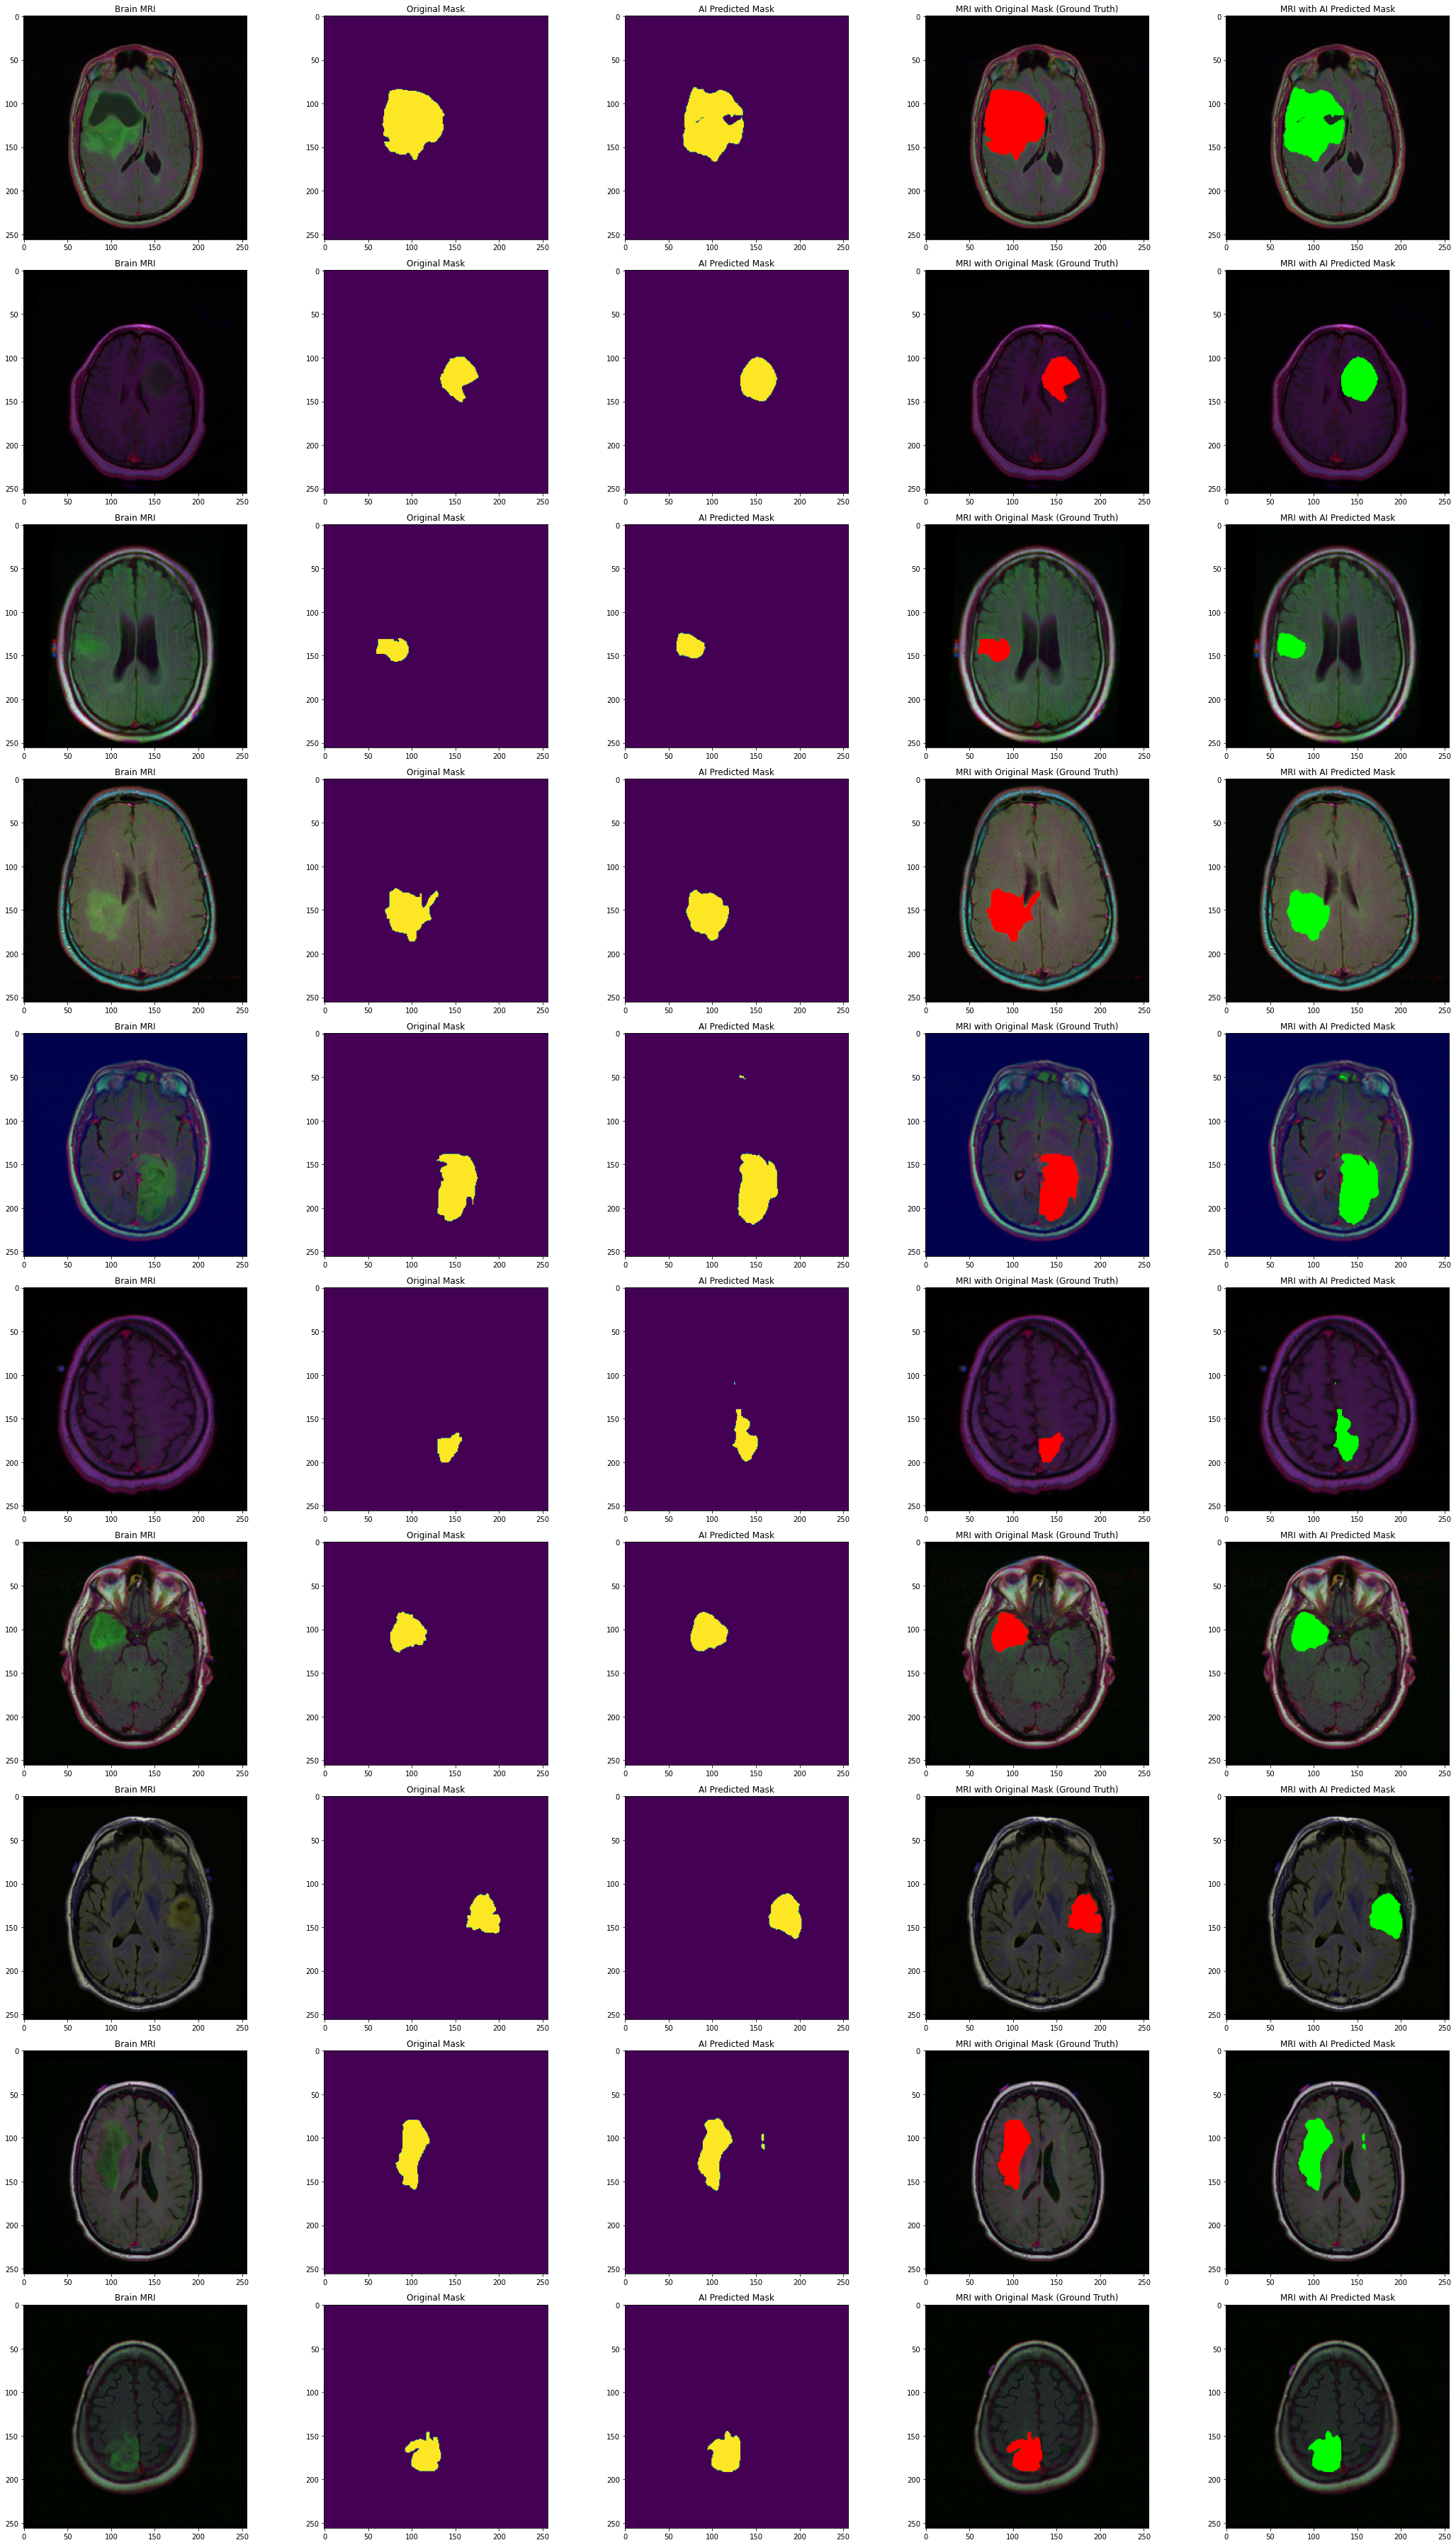

In [ ]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()